# Credit Card Fraud Detection using Homomorphic Encryption Neural Network

This notebook is a proof of concept of running a credit card (CC) fraud detection neural network on encrypted data. A plaintext neural network is first trained using [PyTorch](https://pytorch.org/), and then a private network uses these weights to perform homomorphic encryption (HE) operations with [TenSEAL](https://github.com/OpenMined/TenSEAL). Included in the aims were to keep computation costs down by using a low-layer neural network.

In [1]:
n_estimators = 100
train = True

In [2]:
import sys

from ppxgboost import BoosterParser as boostparser
from ppxgboost import PPBooster as ppbooster
from ppxgboost import PaillierAPI as paillier
from ppxgboost.PPBooster import MetaData
from ppxgboost.PPKey import PPBoostKey
import sys
import random
import time
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from secrets import token_bytes
from ope.pyope.ope import OPE


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn import metrics
import pickle

## Dataset

The dataset used is the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset created by Machine Learning Group - ULB. It consists of 284,807 transactions, 492 of which are fraudulant. 

Each transaction has 30 pieces of information, and a Class of 0 for *valid* or 1 for *fraudulant*. All column names other than Time and Amount have been obfuscated for privacy. In our case, the dataset may not need to have obfuscated column names, as the network could potentially be trained on encrypted data.

In [3]:
# Show the first row of the dataset
data = pd.read_csv('../data/creditcard.csv')
print(data.head(1))

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  

[1 rows x 31 columns]


The percentage of fraudulant transactions in the dataset is very low, which is something we may consider in the design of our network.

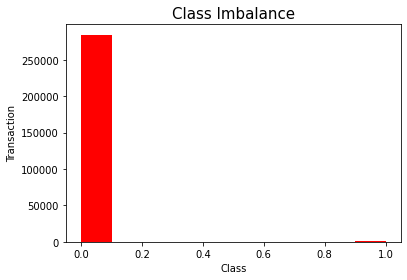

Percentage of fraudulant transactions: 0.17%


In [4]:
# The percentage of fraudulant transactions in the dataset is very low, which is something we may consider in the
# design of our network.
plt.hist(data['Class'], color='red')
plt.xlabel('Class')
plt.ylabel('Transaction')
plt.title('Class Imbalance', fontsize=15)
plt.show()
pc_fraud = len(data.loc[data['Class'] == 1].values)/len(data.loc[data['Class'] == 0].values)
print('Percentage of fraudulant transactions: {:.2f}%'.format(pc_fraud*100))

The data is then preprocessed and split into a dataset for training the network and a dataset for testing it.

In [5]:
# Preprocessing the data by scaling into a [0,1] range and splitting into inputs x and outputs y
x = data.drop('Class', axis=1)
y = data['Class']
# scaler = MinMaxScaler(feature_range=(-1,1))
# scaler.fit(x)
# x = scaler.transform(x)

# Splitting the data into a dataset for training the network and a dataset for testing it
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, shuffle=False)

print('Distribution of each dataset:')
print('Train: %s' % Counter(ytrain))
print('Test: %s' % Counter(ytest))

Distribution of each dataset:
Train: Counter({0: 213207, 1: 398})
Test: Counter({0: 71108, 1: 94})


In [6]:
if train:
    clf = xgb.XGBClassifier( 
            n_estimators=n_estimators,
    #         max_depth=12, 
    #         learning_rate=0.02, 
    #         subsample=0.8,
    #         colsample_bytree=0.4, 
    #         missing=-1, 
    #         eval_metric='auc',
            # USE CPU
    #         nthread=8,
    #         tree_method='hist' 
            # USE GPU
            tree_method='gpu_hist' 
        )

    clf.fit(xtrain, ytrain)
    model = clf.get_booster()

In [7]:
model_filename = 'xgb-uml-clf-{}.txt'.format(n_estimators)
if train:
    pickle.dump(model, open(model_filename, "wb" ))
else:
    model = pickle.load(open(model_filename, "rb"))

## Evaluation

To validate that our Plaintext Model and our HE Model output the same values, we will evaluate a small subset of our test set with each network. Evaluating the full test set with our HE Model would take a lot of time, so we can leave the evaluation of the full test set to the Plaintext Model.

In [8]:
# 1. parsing to internal tree data structure, and output feature set
min_max = boostparser.training_dataset_parser(xtest)
enc_tree, feature_set, min_max = boostparser.model_to_trees(model, min_max)

# 2. Set up encryption materials.
prf_key = token_bytes(16)
public_key, private_key = paillier.he_key_gen()
encrypter = OPE(token_bytes(16))
ppBoostKey = PPBoostKey(public_key, prf_key, encrypter)

In [9]:
# helpers for paralellising the encryption of tree nodes
from joblib import Parallel, delayed
import itertools
def chunk_arr(arr, num_chunks):
    chunk_size = len(arr) // num_chunks
    return [(arr[i:i+chunk_size]) for i in range(0,len(arr),chunk_size)]
    
def dechunk_arr(chunks):
    return list(itertools.chain.from_iterable(chunks))

In [10]:
%%time
# 3. process the tree into enc_tree
output_chunks = Parallel(n_jobs=8)(delayed(ppbooster.enc_xgboost_model)(ppBoostKey, chunk, MetaData(min_max)) for chunk in chunk_arr(enc_tree, 8))
enc_tree = dechunk_arr(output_chunks)

CPU times: user 25 ms, sys: 84.9 ms, total: 110 ms
Wall time: 12.5 s


In [11]:
# Time difference between Plaintext Model and HE Model
sample = xgb.DMatrix(xtest.head(1))
%time model.predict(sample)
encrypted_xtest = xtest.head(1).copy()
%time ppbooster.enc_input_vector(prf_key, encrypter, feature_set, encrypted_xtest, MetaData(min_max))
%time ppbooster.predict_binary(enc_tree, encrypted_xtest)

CPU times: user 1.43 ms, sys: 201 µs, total: 1.63 ms
Wall time: 658 µs
CPU times: user 190 ms, sys: 4.24 ms, total: 195 ms
Wall time: 194 ms
CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 11.5 ms


array([<phe.paillier.EncryptedNumber object at 0x7f0e601ada60>],
      dtype=object)

In [12]:
from sklearn import metrics
def evaluate_predictions(preds, truths, n_estimators, threshold=0.5):
    print('Number of estimators:', n_estimators)
    print('AUPRC score: {}'.format(metrics.average_precision_score(truths, preds)))
    print('AUROC score: {}'.format(metrics.roc_auc_score(truths, preds)))
    preds[preds>=threshold] = 1.0
    preds[preds<threshold] = 0.0
    conf_matrix = metrics.confusion_matrix(truths, preds)
    plt.figure(figsize=(5, 5))
    labels = ["Valid", "Fraud"]
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    print('Accuracy score: {}'.format(metrics.accuracy_score(truths, preds)))
    print(metrics.classification_report(truths, preds))

In [13]:
# We'll take the indices of all the fraudulant transactions in the test set
fraud_test_idxs = ytest==1
# And combine them with an extra 100 transactions
fraud_test_idxs[:100] = True

Evaluation of the sample with the Plaintext Model

CPU times: user 1.91 ms, sys: 0 ns, total: 1.91 ms
Wall time: 1.66 ms
Number of estimators: 100
AUPRC score: 0.9781404470298933
AUROC score: 0.9743617021276596
Accuracy score: 0.845360824742268
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       100
           1       1.00      0.68      0.81        94

    accuracy                           0.85       194
   macro avg       0.88      0.84      0.84       194
weighted avg       0.88      0.85      0.84       194



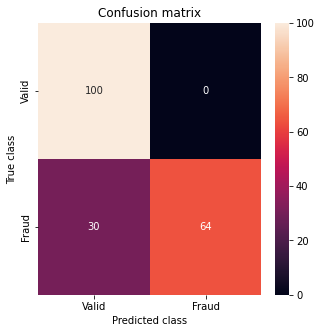

In [14]:
%time results = model.predict(xgb.DMatrix(xtest[fraud_test_idxs]))
evaluate_predictions(results, ytest[fraud_test_idxs], n_estimators)

The most important intuitive metric shown above is the *Confusion matrix* which shows in this case that all 100 valid transactions were successfully labelled as valid, and 79 of the 101 fraudulant transactions were successfully labelled as fraudulant.

Next the sample is evaluated with the HE Model

In [15]:
# 5. privacy-preserving evaluation.
encrypted_xtest = xtest[fraud_test_idxs].copy()
%time encrypted_xtest = Parallel(n_jobs=8)(delayed(ppbooster.enc_input_vector)(prf_key, encrypter, feature_set, chunk, MetaData(min_max)) for chunk in chunk_arr(encrypted_xtest, 8))
encrypted_xtest = pd.concat(encrypted_xtest)
%time results_encrypted = ppbooster.predict_binary(enc_tree, encrypted_xtest)

CPU times: user 8.61 ms, sys: 4.11 ms, total: 12.7 ms
Wall time: 7.41 s
CPU times: user 2.34 s, sys: 2.79 ms, total: 2.34 s
Wall time: 2.34 s


Number of estimators: 100
AUPRC score: 0.9781404470298933
AUROC score: 0.9743617021276596
Accuracy score: 0.845360824742268
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       100
           1       1.00      0.68      0.81        94

    accuracy                           0.85       194
   macro avg       0.88      0.84      0.84       194
weighted avg       0.88      0.85      0.84       194



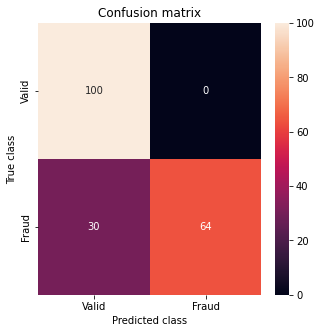

In [16]:
# 6. decryption
results_decrypted = []
for c in results_encrypted:
    results_decrypted.append(paillier.decrypt(private_key, c))
results_decrypted = np.array(results_decrypted).squeeze()

evaluate_predictions(results_decrypted, ytest[fraud_test_idxs], n_estimators)

The same results are found. This demonstrates that the Plaintext Model and teh HE Model both output the same values.

Finally, the full test set is evaluated using the Plaintext Model. This will demonstrate the performance of the weights used in both models.

CPU times: user 18.3 ms, sys: 11.2 ms, total: 29.5 ms
Wall time: 28.1 ms
Number of estimators: 100
AUPRC score: 0.7728706929168722
AUROC score: 0.9821310915730223
Accuracy score: 0.9994943962248252
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71108
           1       0.91      0.68      0.78        94

    accuracy                           1.00     71202
   macro avg       0.96      0.84      0.89     71202
weighted avg       1.00      1.00      1.00     71202



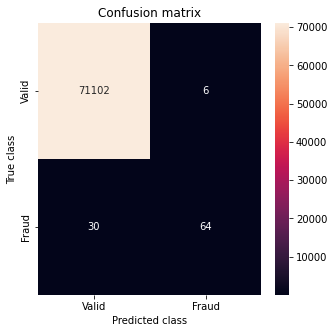

In [17]:
# Evaluation of the full test set with the Plaintext Model
%time results = model.predict(xgb.DMatrix(xtest))
evaluate_predictions(results, ytest, n_estimators)

As shown, 56847 of the 56861 valid transactions are successfully labelled as valid, and 79 of the 101 fraudulant transactions are successfully labelled as fraudulant.

Although these results are not perfect, it concludes the demonstration of how a model can be trained using PyTorch to identify fraudulant CC transactions and then converted into a model that can operate on encrypted inputs using HE.

Some functions for training and evaluation were adapted from this [Kaggle notebook](https://www.kaggle.com/rinabuoy/credit-card-fraud-detection-with-pytorch/notebook) on CC fraud detection.

The HE network is adapted from this official [TenSEAL tutorial](https://github.com/OpenMined/courses/blob/foundations-of-private-computation/homomorphic-encryption/Evaluation%20on%20Encrypted%20Data%20using%20TenSEAL%20-%20Solution.ipynb)